# Emotion Detection model and data collection

# 0. Imports, path and bearer token setup

In [1]:
import tweepy
import csv
import time
import glob
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None
from datetime import timedelta, date
import gzip
import shutil
import os
import wget
from shutil import copyfile
import requests
import json
from sklearn.model_selection import StratifiedKFold
from statistics import mean
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import svm
import time
import numpy as np
import re
import string
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
from ekphrasis.classes.segmenter import Segmenter
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
import collections
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.dates as mdates
# change to your path that you want the notebook to save data files in
path = r'C:\Users\Kamila\Documents\uni\final_year_project'
# change to your bearer token retreived from Twitter Developer API 
# bearer_token = "YOUR TOKEN HERE"

# 1. COVID-19 dataset - download and hydration preparation

# 1.1. Downloading 'daily tweets' dataset from 22/03/2020 to 1/8/2020 (not including)

In [2513]:
# creates a dates range for a given period of time (from start date to end date)
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

# downloads daily tweets for each date from the chosen github repository
def download_datasets(start_date, end_date):
    for single_date in daterange(start_date, end_date):
        stringDate = single_date.strftime("%Y-%m-%d")
        dataset_URL = "https://github.com/thepanacealab/covid19_twitter/blob/master/dailies/" + stringDate + "/" + stringDate + "-dataset.tsv.gz?raw=true"
        
        file_name_gz = stringDate + "-dataset.tsv.gz"
        
        # downloads the dataset (compressed in a GZ format)
        wget.download(dataset_URL, out=file_name_gz)
        
        file_name_tsv = stringDate + "-dataset.tsv"
        # unzips the dataset and gets the TSV dataset
        with gzip.open(file_name_gz, "rb") as f_in:
            with open(file_name_tsv, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
                
        # deletes the compressed GZ file
        os.unlink(file_name_gz)
        
start_date = date(2020, 3, 22)
end_date = date(2020, 8, 1)
download_datasets(start_date, end_date)

# 1.2. Preparing datasets of tweet ids from February and part of March (that are contained in a one, large dataset for months Jan-Mar) for hydration

In [2525]:
# full_dataset_clean contains tweet ids from january, february and part of march, without retweets
full_dataset = pd.read_csv('full_dataset.tsv', sep="\t")
# to hydrate the tweets we only need their ids, so other columns can be dropped; 'date' is kept for month filtering
full_dataset = full_dataset.drop(columns=["time"])

# filtering february tweets
is_february = full_dataset['date'].str.contains("2020-2-")
february = full_dataset[is_february]
print("Number of all tweets from February: ", len(february.index))
# after filtering by month is done, we can drop 'date' column too
february = february.drop(columns=["date"])
# takes a 0.5% sample of tweet ids from that month
sample_february = february.sample(frac=0.08, random_state=111)
sample_february.to_csv(r'2february_dataset_2.tsv', index = False, header = False)
print("Number of SAMPLED tweets from February: ", len(sample_february.index))

# filtering march tweets
is_march = full_dataset['date'].str.contains("2020-3-")
march = full_dataset[is_march]
print("Number of all tweets from part of March: ", len(march.index))
# after filtering by month is done, we can drop 'date' column too
march = march.drop(columns=["date"])
# takes a 0.5% sample of tweet ids from that month
sample_march = march.sample(frac=0.002, random_state=111)
print("Number of SAMPLED tweets from part of March: ", len(sample_march.index))
sample_march.to_csv(r'2march_part1_dataset_2.tsv', index = False, header = False)

Number of all tweets from February:  326611
Number of SAMPLED tweets from February:  26129
Number of all tweets from part of March:  40370731
Number of SAMPLED tweets from part of March:  80741


# 1.3. Preparing datasets of tweet ids from daily datasets (March-Aug) for hydration

In [103]:
# takes a 0.1% sample of tweet ids from daily datasets
def create_sample_datasets(path):
    list_of_datasets = glob.glob(path + "/*-dataset.tsv")

    for dataset_file in list_of_datasets:
        dataset_df = pd.read_csv(dataset_file, sep="\t")
        dataset_df = dataset_df.filter(["tweet_id"])
        sample_dataset_df = dataset_df.sample(frac=0.001)
        new_name = path + "/2_s_" + dataset_file.split("\\")[-1] 
        sample_dataset_df.to_csv(new_name, index = False, header = False, sep="\t")

# concatenates sampled daily dataset of tweet ids into month datasets
def join_datasets_into_months(path, month_names, month_numbers):
    # for each month
    for index in range(len(month_numbers)):
        month_files = glob.glob(path + "/2_s_2020-0" + str(month_numbers[index]) + "*-dataset.tsv")
        filenames = []
        # for each daily dataset
        for day_file in month_files:
            # append to the month filenames list
            filenames.append(day_file)
        # name of the month dataset file
        month_filename = month_names[index] + "_dataset_2.tsv"
        # open the month file and write te daily datasets into it
        with open(month_filename, "w") as outfile:
            for fname in filenames:
                with open(fname) as infile:
                    for line in infile:
                        outfile.write(line)

month_names = ["2march_part2", "2april", "2may", "2june", "2july"]
month_numbers = [3, 4, 5, 6, 7]

join_datasets_into_months(path, month_names, month_numbers)

# 1.4. Concatenate both parts of March into one dataset

In [2687]:
march_part_1 = pd.read_csv('2en_2march_part1_dataset_2.csv', sep=",")
march_part_2 = pd.read_csv('2en_2march_part2_dataset_2.csv', sep=",")
march_frames = [march_part_1, march_part_2]
entire_march_dataset = pd.concat(march_frames, ignore_index=True)
entire_march_dataset
entire_march_dataset.to_csv("2en_2march_dataset_2.csv", index = False, header = True)

# 1.5. Filter hydrated tweet files by language

In [2686]:
# filter out english tweets, add columns for hashtag, information if a tweet is a retweet and text
def prepare_dataframe(dataframe):
    dataframe = dataframe.filter(["created_at", "id", "full_text", "entities", "retweeted_status", "lang"])
    is_en = dataframe['lang']=="en"
    dataframe_en = dataframe[is_en]
    dataframe_en.reset_index(drop=True, inplace=True)
    dataframe_en = dataframe_en.fillna(0)
    dataframe_en['hashtags'] = dataframe_en['entities'].apply(lambda x: x['hashtags'])
    dataframe_en['hashtags'] = dataframe_en['hashtags'].apply(lambda x: [hashtag['text'] for hashtag in x])
    retweets = dataframe_en['retweeted_status'] != 0
    dataframe_en['text'] = dataframe_en['full_text'].apply(lambda x: x if x[0:2] != 'RT' else 0)
    dataframe_en['text'][retweets] = dataframe_en['retweeted_status'][retweets].apply(lambda x: x['full_text'])
    del dataframe_en['full_text']
    del dataframe_en['entities']
    del dataframe_en['retweeted_status']
    return dataframe_en

# convert jsonl files to csv with english tweets only
def jsonl_to_csv(path, files_names):
    files = glob.glob(path + files_names)
    for file in files:
        df = pd.read_json(path_or_buf=file, lines=True)
        new_df = prepare_dataframe(df)
        month_csv = file.split("\\")[-1]
        new_file = path + "/2en_" + month_csv.split(".")[0] + ".csv"
        print(new_file, ": ", len(new_df.index), "english tweets")
        new_df.to_csv(new_file, index = False, header = True)

files_names = "/2*_dataset_2.jsonl"
jsonl_to_csv(path, files_names)

C:\Users\Kamila\Documents\uni\Dissertation/2en_2april_dataset_2.csv :  49825 english tweets
C:\Users\Kamila\Documents\uni\Dissertation/2en_2february_dataset_2.csv :  9919 english tweets
C:\Users\Kamila\Documents\uni\Dissertation/2en_2july_dataset_2.csv :  48447 english tweets
C:\Users\Kamila\Documents\uni\Dissertation/2en_2june_dataset_2.csv :  43391 english tweets
C:\Users\Kamila\Documents\uni\Dissertation/2en_2march_part1_dataset_2.csv :  32282 english tweets
C:\Users\Kamila\Documents\uni\Dissertation/2en_2march_part2_dataset_2.csv :  16696 english tweets
C:\Users\Kamila\Documents\uni\Dissertation/2en_2may_dataset_2.csv :  49761 english tweets


# 1.6. Read datasets into dataframes and concatinate into one big dataset

In [2]:
# run below to read dataset into variable
february_dataset = pd.read_csv('2en_2february_dataset_2.csv', sep=",")
march_dataset = pd.read_csv('2en_2march_dataset_2.csv', sep=",")
april_dataset = pd.read_csv('2en_2april_dataset_2.csv', sep=",")
may_dataset = pd.read_csv('2en_2may_dataset_2.csv', sep=",")
june_dataset = pd.read_csv('2en_2june_dataset_2.csv', sep=",")
july_dataset = pd.read_csv('2en_2july_dataset_2.csv', sep=",")
all_months_dataset = pd.concat([february_dataset, march_dataset, april_dataset, may_dataset, june_dataset, july_dataset], ignore_index=True)

In [3]:
all_months_dataset.head(5)

,created_at,id,lang,hashtags,text
0,2020-02-28 08:19:59+00:00,1233305835968876500,en,[],Live updates: Coronavirus pummels Asian financial markets as deadly outbreak rages https://t.co/ENiHptBctb
1,2020-02-26 16:35:39+00:00,1232705798821863400,en,[],*coronavirus spreads*\n\nnormal countries: oh no! let's hope to find a cure soom\nitaly: WHY ARE OUR PASTA SHELVES EMPTY OH MY GOD ALL WE HAVE LEFT ARE THE PENNE LISCE
2,2020-02-02 17:14:32+00:00,1224018275371225000,en,[],"yixing donated 100,000 rmb through his studio to the wuhan red cross society to help combat coronavirus @layzhang ♥️ https://t.co/kkAVAnIOf5"
3,2020-02-28 16:40:05+00:00,1233431690225184800,en,[],"Mick Mulvaney at CPAC: Coronavirus is the Dem’s new favorite hoax. They want to bring down the President. \n\n- audience cheers\n\nAlso Mick Mulvaney at CPAC: you’ll probably see some schools close.\n\n- audience cheers\n\nNot a fucking cult, though."
4,2020-02-24 18:54:21+00:00,1232015928075968500,en,[],"The coronavirus story will also become a health-insurance story in America. This guy went to China, caught the flu, came back, did the responsible thing and reported himself for possible coronavirus — but tested negative and now might have to pay $1,400+. https://t.co/GdDqyODPVw"


# 1.7. Emoticons/emojis analysis

In [4]:
# count how many tweets contains at least one of the basic emoticons
def contains_emoticons(array):
    emoticons = [":)", ":(", ":-)", ":-(", ":D", ":-D", "XD" "<3"]
    for em in emoticons:
        if em in array:
            return True  
    return False
    
# count how many tweets contains at least one of the basic emojis
def contains_emojis(array):
    emojis = ["🙂", "😊", "🙁", "☹️", "😀", "😃", "😂", "❤️"]
    for em in emojis:
        if em in array:
            return True  
    return False
    
has_basic_emoticons = all_months_dataset['text'].apply(contains_emoticons)
tweets_w_basic_emoticon = all_months_dataset[has_basic_emoticons]
print("COVID-19 dataset:\n", len(tweets_w_basic_emoticon)/len(all_months_dataset) * 100, "% of tweets has emoticons")

has_basic_emojis = all_months_dataset['text'].apply(contains_emojis)
tweets_w_basic_emojis = all_months_dataset[has_basic_emojis]
print(len(tweets_w_basic_emojis)/len(all_months_dataset) * 100, "% of tweets has emojis")

COVID-19 dataset:
 0.07390510584409618 % of tweets has emoticons
0.893253063067022 % of tweets has emojis


# 2. Training dataset - fetching and cleaning 

# 2.1. Fetching dataset

In [208]:
# https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/master/Full-Archive-Search/full-archive-search.py

# defined emotion labels
emotion_hashtags = ['anger', 'fear', 'happiness', 'sadness']

# creates a header with bearer token
def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

# sends a request to twitter endpoint and gets a response back
def connect_to_endpoint(url, headers, params):
    response = requests.request("GET", url, headers=headers, params=params)
    print('status_code:', response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

# converts response into a list of tweets and kees only needed fields in
def json_to_list_of_tweets(json_response):
    list_of_tweets = []
    for tweet in json_response['data']:
        single_tweet = []
        # date and time
        single_tweet.append(tweet['created_at'])
        # hashtags (if exist)
        if 'entities' in tweet and 'hashtags' in tweet['entities']:
            single_tweet.append([hashtag['tag'] for hashtag in tweet['entities']['hashtags']])
        else:
            single_tweet.append([])
        # text 
        single_tweet.append(tweet['text'])
        list_of_tweets.append(single_tweet)
    return list_of_tweets

# fetches tweets with emotion labels as hashtags, assigns the given emotion as label, and creates a dataframe for the entire dataset
def fetch_emotion_tweets(bearer_token, start_dates, end_dates):
    headers = create_headers(bearer_token)
    search_url = "https://api.twitter.com/2/tweets/search/all"
    max_results = 500
    tweet_fields = 'created_at,entities'
    frames = []
    
    for emotion in emotion_hashtags:
        print("Fetching tweets for label:", emotion)
        query = '#' + emotion + ' -is:retweet lang:en'
        for i in range(len(start_dates)):
            # setting query parameters
            query_params = {'query': query,'start_time': start_dates[i],'end_time': end_dates[i],'max_results': max_results,'tweet.fields': tweet_fields}
            # calling the endpoint
            json_response = connect_to_endpoint(search_url, headers, query_params)
            tweets_list = json_to_list_of_tweets(json_response)
            tweets_df = pd.DataFrame(tweets_list, columns=['created_at', 'hashtags', 'text_including_label'])
            # assign label same as the emotion that the tweets were fetched by
            tweets_df['feeling'] = emotion
            # replace the emotion hashtag so that model can learn from other features of tweets
            replace_word = r'#\b' + emotion + r'\b'
            tweets_df['text'] = tweets_df['text_including_label'].apply(lambda x: re.sub(replace_word, ' ', x, flags=re.IGNORECASE))
            print("Fetched", len(tweets_df.index), "tweets for this request")
            frames.append(tweets_df)
            # wait so we don't get 'too many requests' error
            time.sleep(0.1)
    return pd.concat(frames, ignore_index=True)

start_dates_trial1 = ['2019-12-01T00:00:00.00Z', '2019-11-01T00:00:00.00Z', '2019-10-01T00:00:00.00Z', '2019-09-01T00:00:00.00Z', '2019-08-01T00:00:00.00Z', '2019-07-01T00:00:00.00Z', '2019-06-01T00:00:00.00Z', '2019-05-01T00:00:00.00Z', '2019-04-01T00:00:00.00Z', '2019-03-01T00:00:00.00Z', '2019-02-01T00:00:00.00Z', '2019-01-01T00:00:00.00Z', '2018-12-01T00:00:00.00Z', '2018-11-01T00:00:00.00Z', '2018-10-01T00:00:00.00Z', '2018-09-01T00:00:00.00Z', '2018-08-01T00:00:00.00Z', '2018-07-01T00:00:00.00Z', '2018-06-01T00:00:00.00Z', '2018-05-01T00:00:00.00Z', '2018-04-01T00:00:00.00Z', '2018-03-01T00:00:00.00Z', '2018-02-01T00:00:00.00Z', '2018-01-01T00:00:00.00Z']
end_dates_trial1 = ['2019-12-31T00:00:00.00Z', '2019-11-30T00:00:00.00Z', '2019-10-31T00:00:00.00Z', '2019-09-30T00:00:00.00Z', '2019-08-31T00:00:00.00Z', '2019-07-31T00:00:00.00Z', '2019-06-30T00:00:00.00Z', '2019-05-31T00:00:00.00Z', '2019-04-30T00:00:00.00Z', '2019-03-31T00:00:00.00Z', '2019-02-28T00:00:00.00Z', '2019-01-31T00:00:00.00Z', '2018-12-31T00:00:00.00Z', '2018-11-30T00:00:00.00Z', '2018-10-31T00:00:00.00Z', '2018-09-30T00:00:00.00Z', '2018-08-31T00:00:00.00Z', '2018-07-31T00:00:00.00Z', '2018-06-30T00:00:00.00Z', '2018-05-31T00:00:00.00Z', '2018-04-30T00:00:00.00Z', '2018-03-31T00:00:00.00Z', '2018-02-28T00:00:00.00Z', '2018-01-31T00:00:00.00Z']

td_trial2 = fetch_emotion_tweets(bearer_token, start_dates_trial1, end_dates_trial1)
td_trial2.to_csv(r'td_trial2.csv', index = False, header = True)
td_trial2

Fetching tweets for label: anger
status_code: 200
Fetched 497 tweets for this request
status_code: 200
Fetched 497 tweets for this request
status_code: 200
Fetched 499 tweets for this request
status_code: 200
Fetched 499 tweets for this request
status_code: 200
Fetched 499 tweets for this request
status_code: 200
Fetched 499 tweets for this request
status_code: 200
Fetched 499 tweets for this request
status_code: 200
Fetched 499 tweets for this request
status_code: 200
Fetched 500 tweets for this request
status_code: 200
Fetched 498 tweets for this request
status_code: 200
Fetched 500 tweets for this request
status_code: 200
Fetched 499 tweets for this request
status_code: 200
Fetched 500 tweets for this request
status_code: 200
Fetched 500 tweets for this request
status_code: 200
Fetched 500 tweets for this request
status_code: 200
Fetched 499 tweets for this request
status_code: 200
Fetched 500 tweets for this request
status_code: 200
Fetched 497 tweets for this request
status_code: 

,created_at,hashtags,text_including_label,feeling,text
0,2019-12-30T23:46:59.000Z,"[recruiting, careeradvice, anger, worplace, job]",This Psychological Trick Will Help You Let Go Of Anger And Resentment More Quickly https://t.co/pCbxV5WmS6 by @markmurphy #recruiting #careeradvice #anger #worplace #job,anger,This Psychological Trick Will Help You Let Go Of Anger And Resentment More Quickly https://t.co/pCbxV5WmS6 by @markmurphy #recruiting #careeradvice #worplace #job
1,2019-12-30T23:35:44.000Z,"[Pardon, Gracious, Merciful, Slow, Anger]","...a God ready to #Pardon, #Gracious and #Merciful, #Slow to #Anger, and of great kindness..Neh 9:17",anger,"...a God ready to #Pardon, #Gracious and #Merciful, #Slow to , and of great kindness..Neh 9:17"
2,2019-12-30T23:20:05.000Z,"[haiku, poem, anger, relationships, writing, poetry, writingcommunity, poetrycommunity, life, health, mentalhealth, psychology, mindhealth]",// storm circles //\na #haiku #poem about #anger and #relationships\nposted on .@Medium\n\nhttps://t.co/50xmEsgfgD\n#writing #poetry #writingcommunity #poetrycommunity #life #health #mentalhealth #psychology #mindhealth,anger,// storm circles //\na #haiku #poem about and #relationships\nposted on .@Medium\n\nhttps://t.co/50xmEsgfgD\n#writing #poetry #writingcommunity #poetrycommunity #life #health #mentalhealth #psychology #mindhealth
3,2019-12-30T21:29:06.000Z,"[Anger, quote]",#Anger is just anger. It isnt good. It isn't bad. What u do with it is what matters. U can use it to build or to destroy.-Jim Butcher #quote,anger,is just anger. It isnt good. It isn't bad. What u do with it is what matters. U can use it to build or to destroy.-Jim Butcher #quote
4,2019-12-30T21:24:27.000Z,"[Anger, Enemy, MotivationMonday]",Anger and intolerance are the enemies of correct understanding.... #Anger #Enemy #MotivationMonday https://t.co/uKAyYIsbsz https://t.co/OWasa6aMhI,anger,Anger and intolerance are the enemies of correct understanding.... #Enemy #MotivationMonday https://t.co/uKAyYIsbsz https://t.co/OWasa6aMhI
...,...,...,...,...,...
47857,2018-01-22T19:42:21.000Z,"[GH, SarcasmFont, Sadness]","@selfishlady @showbiz411 Oh, yeah! Now my joy is complete! #GH #SarcasmFont #Sadness",sadness,"@selfishlady @showbiz411 Oh, yeah! Now my joy is complete! #GH #SarcasmFont"
47858,2018-01-22T19:22:59.000Z,"[Sadness, VeganFail, VeganAttempts, ITried, MyFriedRiceIsVeganThough]","I tried to be vegan today, but I SO put honey on my banana ... #Sadness #VeganFail #VeganAttempts #ITried #MyFriedRiceIsVeganThough!",sadness,"I tried to be vegan today, but I SO put honey on my banana ... #VeganFail #VeganAttempts #ITried #MyFriedRiceIsVeganThough!"
47859,2018-01-22T19:06:24.000Z,"[seriousquestion, BGNation, nottryingtobesassy, sadness]",How are we supposed to get support for something we can't share?? They're not even using a picture from the right video for the CMT Hot 20 voting.. 😔 #seriousquestion #BGNation #nottryingtobesassy #sadness https://t.co/r5aSYvRlDg,sadness,How are we supposed to get support for something we can't share?? They're not even using a picture from the right video for the CMT Hot 20 voting.. 😔 #seriousquestion #BGNation #nottryingtobesassy https://t.co/r5aSYvRlDg
47860,2018-01-22T18:56:38.000Z,"[sad, sadquotes, depressed, depression, depressionquotes, sadness, alone, depressedquotes, sadquotestumblr, sadpicture, imfine, sadnessquotes, nothappy, cry, crying, tears, hope, l4l, insta, badmood]",‘if this is how my life is going to be... well i don’t want it anymore.’\n-\n-\n-#sad #sadquotes #depressed #depression #depressionquotes #sadness #alone #depressedquotes #sadquotestumblr #sadpicture #imfine #sadnessquotes #nothappy #cry #crying #tears #hope #l4l #insta #badmood,sadness,‘if this is how my life is going to be... well i don’t want it anymore.’\n-\n-\n-#sad #sadquotes #depressed #depression #depressionquotes #alone #depressedquotes #sadquotestumblr #sadpicture #imfine #sadnessquotes #nothappy #cry #crying #tears #hope #l4l #insta #b

In [5]:
# run below to read dataset into variable
td_trial2 = pd.read_csv('td_trial2.csv', sep=",")
td_trial2.tail(3)

,created_at,hashtags,text_including_label,feeling,text
47859,2018-01-22T19:06:24.000Z,"['seriousquestion', 'BGNation', 'nottryingtobesassy', 'sadness']",How are we supposed to get support for something we can't share?? They're not even using a picture from the right video for the CMT Hot 20 voting.. 😔 #seriousquestion #BGNation #nottryingtobesassy #sadness https://t.co/r5aSYvRlDg,sadness,How are we supposed to get support for something we can't share?? They're not even using a picture from the right video for the CMT Hot 20 voting.. 😔 #seriousquestion #BGNation #nottryingtobesassy https://t.co/r5aSYvRlDg
47860,2018-01-22T18:56:38.000Z,"['sad', 'sadquotes', 'depressed', 'depression', 'depressionquotes', 'sadness', 'alone', 'depressedquotes', 'sadquotestumblr', 'sadpicture', 'imfine', 'sadnessquotes', 'nothappy', 'cry', 'crying', 'tears', 'hope', 'l4l', 'insta', 'badmood']",‘if this is how my life is going to be... well i don’t want it anymore.’\n-\n-\n-#sad #sadquotes #depressed #depression #depressionquotes #sadness #alone #depressedquotes #sadquotestumblr #sadpicture #imfine #sadnessquotes #nothappy #cry #crying #tears #hope #l4l #insta #badmood,sadness,‘if this is how my life is going to be... well i don’t want it anymore.’\n-\n-\n-#sad #sadquotes #depressed #depression #depressionquotes #alone #depressedquotes #sadquotestumblr #sadpicture #imfine #sadnessquotes #nothappy #cry #crying #tears #hope #l4l #insta #badmood
47861,2018-01-22T18:41:09.000Z,"['look', 'sadness', 'surprise', 'shelter', 'PleaseShare', 'AdoptADog', 'AdoptDontShop', 'Dogs']",#look at the #sadness and #surprise in those eyes! Poor Blue back in #shelter. #PleaseShare #AdoptADog #AdoptDontShop #Dogs https://t.co/LSUcvShvBW,sadness,#look at the and #surprise in those eyes! Poor Blue back in #shelter. #PleaseShare #AdoptADog #AdoptDontShop #Dogs https://t.co/LSUcvShvBW


# 2.2. Dropping duplicates and contradictory tweets from training dataset

In [6]:
emotion_hashtags = ['anger', 'fear', 'happiness', 'sadness']

# check hashtags for contrasting labels such as 'happy' and sad' so that these tweets can be removed
def must_be_dropped(hashtags):
    if isinstance(hashtags, str):
        hashtags = ast.literal_eval(hashtags)
    set_hashtags = __builtins__.set([hashtag.lower() for hashtag in hashtags])
    sum_emotions = emotion_hashtags
    diff_emotion_hashtags = __builtins__.list(set_hashtags.intersection(sum_emotions))
    number_diff_hashtags = len(diff_emotion_hashtags)
    if number_diff_hashtags < 2:
        return False
    elif number_diff_hashtags > 2:
        return True 
    else:
        if diff_emotion_hashtags[0][:2] == diff_emotion_hashtags[1][:2]:
            return False
        else:
            return True

# remove duplicate tweets and those with contradicting hashtags
def remove_duplicates_and_contradictory(dataframe):
    new_dataframe = dataframe.copy()
    print('length before removing any tweets: ', len(new_dataframe))
    new_dataframe.groupby(['feeling'])['text'].count()
    
    # drop contradictory tweets
    needs_dropping = new_dataframe['hashtags'].apply(must_be_dropped)
    new_dataframe = new_dataframe.drop(new_dataframe[needs_dropping].index)
    new_dataframe.reset_index(drop=True, inplace=True)
    print('length after removing contradicting tweets: ', len(new_dataframe))
    new_dataframe.groupby(['feeling'])['text'].count()
    
    # drop duplicates
    new_dataframe = new_dataframe.drop_duplicates(subset='text', keep="first")
    new_dataframe.reset_index(drop=True, inplace=True)
    print('length after removing duplicate tweets: ', len(new_dataframe))
    new_dataframe.groupby(['feeling'])['text'].count()
    return new_dataframe

In [7]:
training_dataset_v2 = remove_duplicates_and_contradictory(td_trial2)

length before removing any tweets:  47862
length after removing contradicting tweets:  45327
length after removing duplicate tweets:  42392


In [8]:
training_dataset_v2.tail()

,created_at,hashtags,text_including_label,feeling,text
42387,2018-01-22T19:42:21.000Z,"['GH', 'SarcasmFont', 'Sadness']","@selfishlady @showbiz411 Oh, yeah! Now my joy is complete! #GH #SarcasmFont #Sadness",sadness,"@selfishlady @showbiz411 Oh, yeah! Now my joy is complete! #GH #SarcasmFont"
42388,2018-01-22T19:22:59.000Z,"['Sadness', 'VeganFail', 'VeganAttempts', 'ITried', 'MyFriedRiceIsVeganThough']","I tried to be vegan today, but I SO put honey on my banana ... #Sadness #VeganFail #VeganAttempts #ITried #MyFriedRiceIsVeganThough!",sadness,"I tried to be vegan today, but I SO put honey on my banana ... #VeganFail #VeganAttempts #ITried #MyFriedRiceIsVeganThough!"
42389,2018-01-22T19:06:24.000Z,"['seriousquestion', 'BGNation', 'nottryingtobesassy', 'sadness']",How are we supposed to get support for something we can't share?? They're not even using a picture from the right video for the CMT Hot 20 voting.. 😔 #seriousquestion #BGNation #nottryingtobesassy #sadness https://t.co/r5aSYvRlDg,sadness,How are we supposed to get support for something we can't share?? They're not even using a picture from the right video for the CMT Hot 20 voting.. 😔 #seriousquestion #BGNation #nottryingtobesassy https://t.co/r5aSYvRlDg
42390,2018-01-22T18:56:38.000Z,"['sad', 'sadquotes', 'depressed', 'depression', 'depressionquotes', 'sadness', 'alone', 'depressedquotes', 'sadquotestumblr', 'sadpicture', 'imfine', 'sadnessquotes', 'nothappy', 'cry', 'crying', 'tears', 'hope', 'l4l', 'insta', 'badmood']",‘if this is how my life is going to be... well i don’t want it anymore.’\n-\n-\n-#sad #sadquotes #depressed #depression #depressionquotes #sadness #alone #depressedquotes #sadquotestumblr #sadpicture #imfine #sadnessquotes #nothappy #cry #crying #tears #hope #l4l #insta #badmood,sadness,‘if this is how my life is going to be... well i don’t want it anymore.’\n-\n-\n-#sad #sadquotes #depressed #depression #depressionquotes #alone #depressedquotes #sadquotestumblr #sadpicture #imfine #sadnessquotes #nothappy #cry #crying #tears #hope #l4l #insta #badmood
42391,2018-01-22T18:41:09.000Z,"['look', 'sadness', 'surprise', 'shelter', 'PleaseShare', 'AdoptADog', 'AdoptDontShop', 'Dogs']",#look at the #sadness and #surprise in those eyes! Poor Blue back in #shelter. #PleaseShare #AdoptADog #AdoptDontShop #Dogs https://t.co/LSUcvShvBW,sadness,#look at the and #surprise in those eyes! Poor Blue back in #shelter. #PleaseShare #AdoptADog #AdoptDontShop #Dogs https://t.co/LSUcvShvBW


# 2.3. Initial analysis pt. 1 - labels distribution and emoticons/emojis analysis

feeling
anger         9621
fear         10630
happiness    11599
sadness      10542
Name: text, dtype: int64


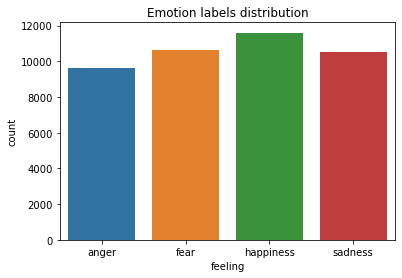

In [9]:
print(training_dataset_v2.groupby(['feeling'])['text'].count())
plt.title("Emotion labels distribution")
sns.countplot(x=(training_dataset_v2['feeling']))

In [11]:
has_basic_emoticons = training_dataset_v2['text'].apply(contains_emoticons)
tweets_w_basic_emoticon = training_dataset_v2[has_basic_emoticons]
print("Training dataset:\n", len(tweets_w_basic_emoticon)/len(training_dataset_v2) * 100, "% of tweets has emoticons")

has_basic_emojis = training_dataset_v2['text'].apply(contains_emojis)
tweets_w_basic_emojis = training_dataset_v2[has_basic_emojis]
print(len(tweets_w_basic_emojis)/len(training_dataset_v2) * 100, "% of tweets has emojis")

Training dataset:
 0.5048122287224005 % of tweets has emoticons
4.757973202491036 % of tweets has emojis


# 3. Preprocessing pt. 1 - functions and training dataset

# 3.1. Functions definitions

In [11]:
# converts the values in 'hashtags' column that are string to list
def hashtags_to_list(hashtags_string):
    return [word for word in hashtags_string.split(' ')]

seg_tw = Segmenter(corpus="twitter")

# segment hashtags into separate words
def segment_hashtags(hashtags):
    seg_hashtags = []
    for hashtag in hashtags:
        segmented_hashtag = seg_tw.segment(hashtag)
        seg_hashtags.append(segmented_hashtag)
    return seg_hashtags

# replaces hashtags in text with segmented hashtags
def replace_hashags_with_segmented(text, hashtags):
    segmented_hashtags = segment_hashtags(hashtags)
    hashtags_regular = ['#' + hashtag for hashtag in hashtags]
    hashtags_with_spacer = ['\n#' + hashtag for hashtag in hashtags]
    hashtags = hashtags_regular + hashtags_with_spacer
    segmented_hashtags = segmented_hashtags * 2
    dict_of_hashtags = dict(zip(hashtags, segmented_hashtags))
    return ' '.join(dict_of_hashtags[word] if word in dict_of_hashtags else word for word in text.split(' '))

# finds new text values with segmented hashtags for a dataframe
def first_cleaning(dataframe):
    new_column_values = []
    for index, row in dataframe.iterrows():
        hashtags = row['hashtags']
        if hashtags == 0:
            continue
        if isinstance(hashtags, str):
            hashtags = ast.literal_eval(hashtags)
        new_value = replace_hashags_with_segmented(row['text'], hashtags)
        new_column_values.append(new_value)
    return new_column_values

# abbreviation management
abbreviation_file = open("old_abbr.txt", "r")
a_contents = abbreviation_file.read()
abbr = ast.literal_eval(a_contents)
abbreviation_file.close()

def convert_abbreviations(text):
    return ' '.join(abbr[w] if w in abbr else w for w in text.split(' '))

def curly_to_straight_quote(text):
    return re.sub(r'’', r"'", text)
    
    
# lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_tokens(tokens):
    words_with_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = []
    for pair in words_with_tags:
        word = pair[0]
        tag = nltk_tag_to_wordnet_tag(pair[1])
        if tag is None:
            lemmatized_tokens.append(word)
        else:
            lemmatized_tokens.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_tokens


# tokenization
w_tokenizer = TweetTokenizer()

def tokenize_text(text):
    return w_tokenizer.tokenize(text)


# stemming
from nltk.stem import LancasterStemmer
stemmer = nltk.stem.LancasterStemmer()

def stem_tokens(tokens):
    return [(stemmer.stem(w)) for w in tokens]


# correct elongated words
def replace_elongated(word):
    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replace_elongated(repl_word)
    else:       
        return repl_word

def replace_elong_words(words):
    new_words = []
    for word in words:
        new_word = replace_elongated(word)
        new_words.append(new_word)
    return new_words


# remove punctuation
def remove_punctuation_and_white_spaces(words):
    new_words = []
    for word in words:
        # Removing punctuations in string using regex 
        new_word = re.sub(r'[_]+|[^\w\s]+', '', (word))
        new_word = re.sub(r"\s+", "", new_word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_punc_keep_emojis(text):
    return re.sub('[%s]' % re.escape(string.punctuation), ' ', text)


# stopwords removal
def remove_words(words, words_to_be_removed):
    return words.apply(lambda x: [item for item in x if item not in words_to_be_removed])

tweet_keywords = ['rt','rts','retweet','via','twitter','tweet','tweets']
stop_words = __builtins__.set().union(stopwords.words('english'), tweet_keywords)
stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('nor')

def preprocess_data(data, replace_abrreviation=True, lemma=True, stem=False, remove_punctuation=True, remove_emojis=False, remove_stopwords=False):
    # get rid of line spacers 
    data = data.apply(lambda x: re.sub(r'/(\r\n\t)+|\r+|\n+|\t+/', '. ', x))
    # remove curly quote marks
    data = data.apply(curly_to_straight_quote)
    if replace_abrreviation:
        print("Replacing abbreviations...")
        # convert abbreviations
        data = data.apply(convert_abbreviations)   
    # convert to lower case
    data = data.str.lower()
    # get rid of numbers
    data = data.astype(str).str.replace('\d+', '', regex=True)
    # remove URLs and usernames
    data = data.apply(lambda x: re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', x))
    data = data.apply(lambda x: re.sub(r'http\S+', '', x))
    data = data.apply(lambda x: re.sub('@[^\s]+', '', x))
    # remove &text; html chars
    data = data.apply(lambda x: re.sub(r'&[a-z]+;', '', x))
    # remove punctuation apart from emojis and a few special signs
    if (remove_punctuation and (remove_emojis == False)):
        print("Removing punctuation...")
        data = data.apply(remove_punc_keep_emojis)
    # tokenise
    print("Tokenising...")
    data = data.apply(tokenize_text)
    # remove all signs that aren't letter
    if (remove_punctuation and remove_emojis):
        print("Removing punctuation and emojis...")
        data = data.apply(remove_punctuation_and_white_spaces)        
    # lemmatise the words
    if lemma:
        print("Lemmatising ...")
        data = data.apply(lemmatize_tokens)
    if stem:
        print("Stemming...")
        data = data.apply(stem_tokens)
    # remove words that need to be removed
    if remove_stopwords:
        print("Removing english stopwords...")
        data = remove_words(data, stop_words)
    else:
        print("Removing tweet keywords...")
        data = remove_words(data, tweet_keywords)
    return pd.DataFrame(data)  

Reading twitter - 1grams ...
Reading twitter - 2grams ...


In [16]:
print(stop_words)

{"don't", 'won', 'other', 'some', 'few', 'own', 'what', 'he', 'aren', 'didn', 'through', 'retweet', 'ain', 'where', 'only', 'such', 'any', 'shan', 'above', "wouldn't", "you're", 'and', 'over', 'more', 'don', 'her', 'yours', 'up', 'than', 'via', "it's", 'off', 'for', 'y', 'd', 've', 'whom', "couldn't", 'their', 'isn', 'as', 'am', 'hers', 'our', "isn't", 'has', "won't", 'in', 'theirs', 'of', 'after', 'are', 'should', 'were', 'do', 'during', "hasn't", 'weren', 'myself', "you'll", "wasn't", 'tweets', 'those', 'further', 'haven', 'rts', "haven't", "hadn't", 'against', 'themselves', 'before', 'ma', 'when', 'did', "you'd", 'hasn', 'i', 'this', "she's", 'his', 'she', 'down', 'they', 'because', 'too', 'which', 'below', 'you', 'who', 'with', 'o', 'was', 'most', 'hadn', "weren't", 'wasn', 'we', 'here', 'about', 'how', 'my', 'by', 'wouldn', 'yourselves', 'had', 'have', 'same', "shouldn't", 'both', 'doing', 'now', 'once', 'is', 'tweet', 'if', 'at', 'very', 'needn', 'but', 'there', 'a', 'herself', '

# 3.2. Training dataset

In [13]:
# first cleaning of the training dataset
def clean_training_dataset(raw_dataset):
    dataset = raw_dataset.copy()
    # fill all 'NaN' values with an empty string
    dataset = dataset.fillna('')
    # segments hashtags in text
    dataset_text_segmented_hashtags = first_cleaning(dataset)
    dataset['segmented_#_text'] = dataset_text_segmented_hashtags
    return dataset
    
# preprocess dataset according to set parameters
def preprocess_training_dataset(clean_dataset, replace_abrreviation=True, lemma=True, stem=False, remove_punctuation=True, remove_emojis=False, remove_stopwords=False):
    dataset = clean_dataset.copy()
    # preprocesses the text with segmented hashtags
    dataset['pre_text'] = preprocess_data(dataset['segmented_#_text'], replace_abrreviation, lemma, stem, remove_punctuation, remove_emojis, remove_stopwords)
    # count how many words there are after preprocessing, as some will have to be dropped later on
    dataset['pre_num_of_words'] = dataset['pre_text'].apply(len)
    return dataset

# removes tweets shorter than set parameter from a dataset
def remove_tweets_shorter_than(length, longer_dataset):
    dataset = longer_dataset.copy()
    dataset = dataset.drop(dataset[dataset.pre_num_of_words < length].index)
    dataset.reset_index(drop=True, inplace=True)
    return dataset

In [14]:
clean_td = clean_training_dataset(training_dataset_v2)
clean_td.to_csv("clean_td.csv", sep=",", index=False)

In [15]:
# run below to read dataset into variable
clean_td = pd.read_csv('clean_td.csv', sep=",")

In [16]:
clean_td.head(3)

,created_at,hashtags,text_including_label,feeling,text,segmented_#_text
0,2019-12-30T23:46:59.000Z,"['recruiting', 'careeradvice', 'anger', 'worplace', 'job']",This Psychological Trick Will Help You Let Go Of Anger And Resentment More Quickly https://t.co/pCbxV5WmS6 by @markmurphy #recruiting #careeradvice #anger #worplace #job,anger,This Psychological Trick Will Help You Let Go Of Anger And Resentment More Quickly https://t.co/pCbxV5WmS6 by @markmurphy #recruiting #careeradvice #worplace #job,This Psychological Trick Will Help You Let Go Of Anger And Resentment More Quickly https://t.co/pCbxV5WmS6 by @markmurphy recruiting career advice wor place job
1,2019-12-30T23:35:44.000Z,"['Pardon', 'Gracious', 'Merciful', 'Slow', 'Anger']","...a God ready to #Pardon, #Gracious and #Merciful, #Slow to #Anger, and of great kindness..Neh 9:17",anger,"...a God ready to #Pardon, #Gracious and #Merciful, #Slow to , and of great kindness..Neh 9:17","...a God ready to #Pardon, gracious and #Merciful, slow to , and of great kindness..Neh 9:17"
2,2019-12-30T23:20:05.000Z,"['haiku', 'poem', 'anger', 'relationships', 'writing', 'poetry', 'writingcommunity', 'poetrycommunity', 'life', 'health', 'mentalhealth', 'psychology', 'mindhealth']",// storm circles //\na #haiku #poem about #anger and #relationships\nposted on .@Medium\n\nhttps://t.co/50xmEsgfgD\n#writing #poetry #writingcommunity #poetrycommunity #life #health #mentalhealth #psychology #mindhealth,anger,// storm circles //\na #haiku #poem about and #relationships\nposted on .@Medium\n\nhttps://t.co/50xmEsgfgD\n#writing #poetry #writingcommunity #poetrycommunity #life #health #mentalhealth #psychology #mindhealth,// storm circles //\na haiku poem about and #relationships\nposted on .@Medium\n\nhttps://t.co/50xmEsgfgD\n#writing poetry writing community poetry community life health mental health psychology mind health


# 4. ED models  

# 4.1. Functions definitions

In [17]:
# helper function for initialising TF-IDF when text was already tokenised and preprocessed
def dummy_fun(doc):
    return doc

# metrics by which we evaluate our models
scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy']

# runs SVM model and returns metrics' values
def run_svm(X, y):
    clf = svm.LinearSVC(C=1, random_state=1)
    scores = cross_validate(clf, X, y, cv=10, scoring=scoring)
    return scores

# runs nb model and returns metrics' values
def run_nb(X, y):
    clf = MultinomialNB()
    scores = cross_validate(clf, X, y, cv=10, scoring=scoring)
    return scores

# runs experiment using given preprocessed dataset and classifier name
def run_experiment(preprocessed_training_dataset, clf):
    tfidf = TfidfVectorizer(analyzer='word', min_df=5, preprocessor=dummy_fun, tokenizer=dummy_fun, ngram_range=(1,2))
    X = tfidf.fit_transform(preprocessed_training_dataset['pre_text'])
    lb = LabelEncoder()
    y = lb.fit_transform(preprocessed_training_dataset['feeling'])
    if clf == "svm":
        return run_svm(X, y)
    else:
        return run_nb(X, y)
    
pd.options.display.float_format = '{:,.3f}'.format

# 4.2. ED models - experiments and comparisons

# 4.2.1. Lemmatization vs stemming 

In [18]:
# preprocess training dataset
lemma_td = preprocess_training_dataset(clean_td, replace_abrreviation=True, lemma=True, stem=False, remove_punctuation=True, remove_emojis=False, remove_stopwords=True)
stem_td = preprocess_training_dataset(clean_td, replace_abrreviation=True, lemma=False, stem=True, remove_punctuation=True, remove_emojis=False, remove_stopwords=True)

# svm
svm_lemma_score = pd.DataFrame.from_dict(run_experiment(lemma_td, "svm")).describe().rename(index={"mean": "svm_lemma_score"}).iloc[1:2]
svm_stem_score = pd.DataFrame.from_dict(run_experiment(stem_td, "svm")).describe().rename(index={"mean": "svm_stem_score"}).iloc[1:2]

# nb
nb_lemma_score = pd.DataFrame.from_dict(run_experiment(lemma_td, "nb")).describe().rename(index={"mean": "nb_lemma_score"}).iloc[1:2]
nb_stem_score = pd.DataFrame.from_dict(run_experiment(stem_td, "nb")).describe().rename(index={"mean": "nb_stem_score"}).iloc[1:2]

comparison_1 = pd.concat([svm_lemma_score, svm_stem_score, nb_lemma_score, nb_stem_score])
comparison_1

Replacing abbreviations...
Removing punctuation...
Tokenising...
Lemmatising ...
Removing english stopwords...
Replacing abbreviations...
Removing punctuation...
Tokenising...
Stemming...
Removing english stopwords...


,fit_time,score_time,test_precision_macro,test_recall_macro,test_f1_macro,test_accuracy
svm_lemma_score,1.154,0.007,0.778,0.775,0.776,0.777
svm_stem_score,0.894,0.008,0.774,0.770,0.771,0.773
nb_lemma_score,0.014,0.006,0.763,0.751,0.753,0.756
nb_stem_score,0.016,0.007,0.762,0.751,0.752,0.755


# 4.2.2. Keep abbreviations in vs replace abbreviations

In [42]:
# preprocess training dataset
keep_abr_td = preprocess_training_dataset(clean_td, replace_abrreviation=False, lemma=True, stem=False, remove_punctuation=True, remove_emojis=False, remove_stopwords=True)
replace_abr_td = lemma_td.copy()

# svm
svm_keep_abr_score = pd.DataFrame.from_dict(run_experiment(keep_abr_td, "svm")).describe().rename(index={"mean": "svm_keep_abr_score"}).iloc[1:2]
svm_replace_abr_score = pd.DataFrame.from_dict(run_experiment(replace_abr_td, "svm")).describe().rename(index={"mean": "svm_replace_abr_score"}).iloc[1:2]

# nb
nb_keep_abr_score = pd.DataFrame.from_dict(run_experiment(keep_abr_td, "nb")).describe().rename(index={"mean": "nb_keep_abr_score"}).iloc[1:2]
nb_replace_abr_score = pd.DataFrame.from_dict(run_experiment(replace_abr_td, "nb")).describe().rename(index={"mean": "nb_replace_abr_score"}).iloc[1:2]

comparison_2 = pd.concat([svm_keep_abr_score, svm_replace_abr_score, nb_keep_abr_score, nb_replace_abr_score])
comparison_2

Removing punctuation...
Tokenising...
Lemmatising ...
Removing english stopwords...


,fit_time,score_time,test_precision_macro,test_recall_macro,test_f1_macro,test_accuracy
svm_keep_abr_score,0.789,0.005,0.778,0.774,0.775,0.777
svm_replace_abr_score,0.774,0.006,0.778,0.775,0.776,0.777
nb_keep_abr_score,0.016,0.006,0.762,0.751,0.752,0.756
nb_replace_abr_score,0.015,0.006,0.763,0.751,0.753,0.756


# 4.2.3. Keep punctuation in vs remove punctuation

In [51]:
# preprocess training dataset
keep_punc_td = preprocess_training_dataset(clean_td, replace_abrreviation=True, lemma=True, stem=False, remove_punctuation=False, remove_emojis=False, remove_stopwords=True)
remove_punc_td = lemma_td.copy()

# svm
svm_keep_punc_score = pd.DataFrame.from_dict(run_experiment(keep_punc_td, "svm")).describe().rename(index={"mean": "svm_keep_punc_score"}).iloc[1:2]
svm_remove_punc_score = pd.DataFrame.from_dict(run_experiment(remove_punc_td, "svm")).describe().rename(index={"mean": "svm_remove_punc_score"}).iloc[1:2]

# nb
nb_keep_punc_score = pd.DataFrame.from_dict(run_experiment(keep_punc_td, "nb")).describe().rename(index={"mean": "nb_keep_punc_score"}).iloc[1:2]
nb_remove_punc_score = pd.DataFrame.from_dict(run_experiment(remove_punc_td, "nb")).describe().rename(index={"mean": "nb_remove_punc_score"}).iloc[1:2]

comparison_3 = pd.concat([svm_keep_punc_score, svm_remove_punc_score, nb_keep_punc_score, nb_remove_punc_score])
comparison_3

Replacing abbreviations...
Tokenising...
Lemmatising ...
Removing english stopwords...


,fit_time,score_time,test_precision_macro,test_recall_macro,test_f1_macro,test_accuracy
svm_keep_punc_score,1.052,0.006,0.774,0.771,0.771,0.773
svm_remove_punc_score,0.920,0.006,0.778,0.775,0.776,0.777
nb_keep_punc_score,0.019,0.007,0.764,0.751,0.753,0.756
nb_remove_punc_score,0.015,0.006,0.763,0.751,0.753,0.756


# 4.2.4. Keep emojis in vs remove emojis

In [44]:
# preprocess training dataset
keep_emojis_td = lemma_td.copy()
remove_emojis_td = preprocess_training_dataset(clean_td, replace_abrreviation=True, lemma=True, stem=False, remove_punctuation=True, remove_emojis=True, remove_stopwords=True)

# svm
svm_keep_emojis_score = pd.DataFrame.from_dict(run_experiment(keep_emojis_td, "svm")).describe().rename(index={"mean": "svm_keep_emojis_score"}).iloc[1:2]
svm_remove_emojis_score = pd.DataFrame.from_dict(run_experiment(remove_emojis_td, "svm")).describe().rename(index={"mean": "svm_remove_emojis_score"}).iloc[1:2]

# nb
nb_keep_emojis_score = pd.DataFrame.from_dict(run_experiment(keep_emojis_td, "nb")).describe().rename(index={"mean": "nb_keep_emojis_score"}).iloc[1:2]
nb_remove_emojis_score = pd.DataFrame.from_dict(run_experiment(remove_emojis_td, "nb")).describe().rename(index={"mean": "nb_remove_emojis_score"}).iloc[1:2]

comparison_4 = pd.concat([svm_keep_emojis_score, svm_remove_emojis_score, nb_keep_emojis_score, nb_remove_emojis_score])
comparison_4

Replacing abbreviations...
Tokenising...
Removing punctuation and emojis...
Lemmatising ...
Removing english stopwords...


,fit_time,score_time,test_precision_macro,test_recall_macro,test_f1_macro,test_accuracy
svm_keep_emojis_score,0.826,0.006,0.778,0.775,0.776,0.777
svm_remove_emojis_score,0.770,0.006,0.773,0.769,0.770,0.772
nb_keep_emojis_score,0.015,0.006,0.763,0.751,0.753,0.756
nb_remove_emojis_score,0.015,0.006,0.760,0.750,0.751,0.754


# 4.2.5. Keep stopwords in vs remove stopwords

In [45]:
# preprocess training dataset
keep_stopwords_td = preprocess_training_dataset(clean_td, replace_abrreviation=True, lemma=True, stem=False, remove_punctuation=True, remove_emojis=False, remove_stopwords=False)
remove_stopwords_td = lemma_td.copy()

# svm
svm_keep_stopwords_score = pd.DataFrame.from_dict(run_experiment(keep_stopwords_td, "svm")).describe().rename(index={"mean": "svm_keep_stopwords_score"}).iloc[1:2]
svm_remove_stopwords_score = pd.DataFrame.from_dict(run_experiment(remove_stopwords_td, "svm")).describe().rename(index={"mean": "svm_remove_stopwords_score"}).iloc[1:2]

# nb
nb_keep_stopwords_score = pd.DataFrame.from_dict(run_experiment(keep_stopwords_td, "nb")).describe().rename(index={"mean": "nb_keep_stopwords_score"}).iloc[1:2]
nb_remove_stopwords_score = pd.DataFrame.from_dict(run_experiment(remove_stopwords_td, "nb")).describe().rename(index={"mean": "nb_remove_stopwords_score"}).iloc[1:2]

comparison_5 = pd.concat([svm_keep_stopwords_score,svm_remove_stopwords_score, nb_keep_stopwords_score, nb_remove_stopwords_score])
comparison_5

Replacing abbreviations...
Removing punctuation...
Tokenising...
Lemmatising ...
Removing tweet keywords...


,fit_time,score_time,test_precision_macro,test_recall_macro,test_f1_macro,test_accuracy
svm_keep_stopwords_score,1.207,0.000,0.780,0.776,0.777,0.778
svm_remove_stopwords_score,0.905,0.008,0.778,0.775,0.776,0.777
nb_keep_stopwords_score,0.031,0.000,0.768,0.754,0.755,0.759
nb_remove_stopwords_score,0.015,0.006,0.763,0.751,0.753,0.756


# 4.2.6. Remove tweets shorter than 4 words long vs keep all tweets in

In [46]:
# preprocess training dataset for svm
remove_shorter_tweets_td = remove_tweets_shorter_than(4, keep_stopwords_td)
keep_shorter_tweets_td = keep_stopwords_td.copy()

# svm
svm_remove_tweets_score = pd.DataFrame.from_dict(run_experiment(remove_shorter_tweets_td, "svm")).describe().rename(index={"mean": "svm_remove_tweets_score"}).iloc[1:2]
svm_keep_all_score = pd.DataFrame.from_dict(run_experiment(keep_shorter_tweets_td, "svm")).describe().rename(index={"mean": "svm_keep_all_score"}).iloc[1:2]

# nb
nb_remove_tweets_score = pd.DataFrame.from_dict(run_experiment(remove_shorter_tweets_td, "nb")).describe().rename(index={"mean": "nb_remove_tweets_score"}).iloc[1:2]
nb_keep_all_score = pd.DataFrame.from_dict(run_experiment(keep_shorter_tweets_td, "nb")).describe().rename(index={"mean": "nb_keep_all_score"}).iloc[1:2]

comparison_6 = pd.concat([svm_remove_tweets_score,svm_keep_all_score, nb_remove_tweets_score, nb_keep_all_score])
comparison_6

,fit_time,score_time,test_precision_macro,test_recall_macro,test_f1_macro,test_accuracy
svm_remove_tweets_score,1.207,0.008,0.782,0.778,0.779,0.781
svm_keep_all_score,1.215,0.007,0.780,0.776,0.777,0.778
nb_remove_tweets_score,0.024,0.013,0.770,0.756,0.757,0.761
nb_keep_all_score,0.017,0.015,0.768,0.754,0.755,0.759


In [47]:
print("before removing any tweets: ", len(keep_shorter_tweets_td), "\n after removing tweets shorter than 4 words long: ", len(remove_shorter_tweets_td))

before removing any tweets:  42392 
 after removing tweets shorter than 4 words long:  42059


In [48]:
final_training_dataset = remove_shorter_tweets_td.copy()
final_training_dataset.to_csv("final_training_dataset.tsv", sep="\t", index=False, header=True)

In [7]:
# run below to read dataset into variable
final_training_dataset = pd.read_csv('final_training_dataset.tsv', sep="\t")
final_training_dataset['pre_text'] = final_training_dataset['pre_text'].apply(ast.literal_eval)

In [39]:
final_training_dataset.tail(15)

,created_at,hashtags,text_including_label,feeling,text,segmented_#_text,pre_text,pre_num_of_words
42044,2018-01-22T21:52:11.000Z,['Sadness'],"@MimiDC4L Spinelli's supposed to be a PI so he really should grab a clue.. His ""friend"" doesn't do anything she doesn't want to do. I thought he knew her. Turns out he only sees the Sam he wants to see. And NONE of them can see her without JASON. #Sadness",sadness,"@MimiDC4L Spinelli's supposed to be a PI so he really should grab a clue.. His ""friend"" doesn't do anything she doesn't want to do. I thought he knew her. Turns out he only sees the Sam he wants to see. And NONE of them can see her without JASON.","@MimiDC4L Spinelli's supposed to be a PI so he really should grab a clue.. His ""friend"" doesn't do anything she doesn't want to do. I thought he knew her. Turns out he only sees the Sam he wants to see. And NONE of them can see her without JASON.","[spinelli, s, suppose, to, be, a, pi, so, he, really, should, grab, a, clue, his, friend, do, not, do, anything, she, do, not, want, to, do, i, thought, he, know, her, turn, out, he, only, see, the, sam, he, want, to, see, and, none, of, them, can, see, her, without, jason]",51
42045,2018-01-22T21:52:07.000Z,"['depressed', 'depression', 'depressedquotes', 'demilovato', 'sadness', 'snow', 'cold', 'shadows', 'ish_c', 'fuckdepression', 'followme']",Cold world of depression! #depressed #depression #depressedquotes #demilovato #sadness #snow #cold #shadows #ish_c.a#fuckthepain #fuckdepression #followme https://t.co/WignGwogYa https://t.co/n9sy191xcx,sadness,Cold world of depression! #depressed #depression #depressedquotes #demilovato #snow #cold #shadows #ish_c.a#fuckthepain #fuckdepression #followme https://t.co/WignGwogYa https://t.co/n9sy191xcx,Cold world of depression! depressed depression depressed quotes demi lovato snow cold shadows #ish_c.a#fuckthepain fuck depression follow me https://t.co/WignGwogYa https://t.co/n9sy191xcx,"[cold, world, of, depression, depress, depression, depress, quote, demi, lovato, snow, cold, shadow, ish, c, a, fuckthepain, fuck, depression, follow, me]",21
42046,2018-01-22T21:52:07.000Z,"['depressed', 'depression', 'depressedquotes', 'demilovato', 'sadness', 'snow', 'cold', 'shadows', 'ish_c', 'fuckdepression', 'followme']",Cold world of depression! #depressed #depression #depressedquotes #demilovato #sadness #snow #cold #shadows #ish_c.a#fuckthepain #fuckdepression #followme https://t.co/WignGwogYa https://t.co/cyAK9S1WFI,sadness,Cold world of depression! #depressed #depression #depressedquotes #demilovato #snow #cold #shadows #ish_c.a#fuckthepain #fuckdepression #followme https://t.co/WignGwogYa https://t.co/cyAK9S1WFI,Cold world of depression! depressed depression depressed quotes demi lovato snow cold shadows #ish_c.a#fuckthepain fuck depression follow me https://t.co/WignGwogYa https://t.co/cyAK9S1WFI,"[cold, world, of, depression, depress, depression, depress, quote, demi, lovato, snow, cold, shadow, ish, c, a, fuckthepain, fuck, depression, follow, me]",21
42047,2018-01-22T21:51:57.000Z,"['depressed', 'depression', 'depressedquotes', 'demilovato', 'sadness', 'snow']",Cold world of depression! #depressed #depression #depressedquotes #demilovato #sadness #snow… https://t.co/gBD1ERRuoA,sadness,Cold world of depression! #depressed #depression #depressedquotes #demilovato #snow… https://t.co/gBD1ERRuoA,Cold world of depression! depressed depression depressed quotes demi lovato #snow… https://t.co/gBD1ERRuoA,"[cold, world, of, depression, depress, depression, depress, quote, demi, lovato, snow, …]",12
42048,2018-01-22T21:01:03.000Z,"['hate', 'sadness', 'plasticfan']",@Dani14Baz That’s so creative and cheap #hate #sadness #plasticfan,sadness,@Dani14Baz That’s so creative and cheap #hate #plasticfan,@Dani14Baz That’s so creative and cheap hate plastic fan,"[that, s, so, creative, and, cheap, hate, plastic, fan]",9
42049,2018-01-22T21:00:08.000Z,"['EssentialOil', 'Sadness']",One of my favorite #EssentialOi

# 5. Final ED model - SVM

SVM with the training dataset preprocessed according to the best scenario: lemmatization, abbreviation replacement, punctuation removal, keeping emojis in, keeping most stopwords, tweets shorter than 4 words long removal

# 5.1. ED model training, testing and evaluation

In [11]:
# preprocessed training dataset and chosen ED classifier - SVM
final_classifier = svm.LinearSVC(C=1, random_state=1)
    
# dataset split, feature extraction and selection, labels' transformation into numerical values
train_X, test_X, train_y, test_y = train_test_split(final_training_dataset["pre_text"], final_training_dataset["feeling"], train_size=0.9, random_state=1)
final_tfidf = TfidfVectorizer(analyzer='word', min_df=5, preprocessor=dummy_fun, tokenizer=dummy_fun, ngram_range=(1,2))
x_train_features = final_tfidf.fit_transform(train_X)
x_test_features = final_tfidf.transform(test_X)

lb = LabelEncoder()
y_train = lb.fit_transform(train_y)
y_test = lb.transform(test_y)

# train classifier, predict new labels
final_classifier.fit(x_train_features, y_train)
emotions_predicted = final_classifier.predict(x_test_features)

print(metrics.classification_report(y_test, emotions_predicted))

              precision    recall  f1-score   support

           0       0.82      0.77      0.80       984
           1       0.79      0.78      0.79      1040
           2       0.82      0.85      0.84      1142
           3       0.77      0.79      0.78      1040

    accuracy                           0.80      4206
   macro avg       0.80      0.80      0.80      4206
weighted avg       0.80      0.80      0.80      4206



Confusion matrix, without normalization
[[759  84  54  87]
 [ 67 816  67  90]
 [ 31  71 973  67]
 [ 63  67  91 819]]


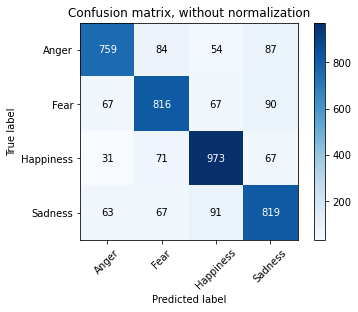

In [12]:
names = ['Anger','Fear', 'Happiness', 'Sadness']

# plots confusion matrix based on predicted and true labels
def plot_confusion_matrix(cm, title, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    thresh = cm.max() / 1.5
    for (j,i),label in np.ndenumerate(cm):
        plt.text(i,j,label,ha='center',va='center',color="white" if cm[i, j] > thresh else "black")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# calculates and plots confusion matrix based on predicted and true labels
def prepare_confusion_matrix(normalised, true_labels, predictions):
    cm = confusion_matrix(true_labels, predictions)
    np.set_printoptions(precision=2)
    if normalised:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        title = 'Normalized confusion matrix'
        print(title)
        print(cm)
    else:
        title = 'Confusion matrix, without normalization'
        print(title)
        print(cm)
    plt.figure()
    plot_confusion_matrix(cm, title=title)
    
prepare_confusion_matrix(False, y_test, emotions_predicted)

Normalized confusion matrix
[[0.77 0.09 0.05 0.09]
 [0.06 0.78 0.06 0.09]
 [0.03 0.06 0.85 0.06]
 [0.06 0.06 0.09 0.79]]


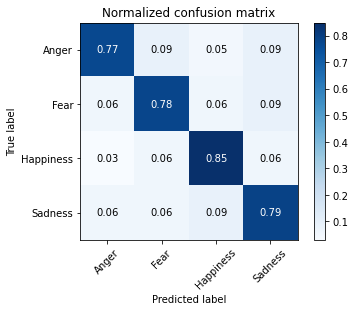

In [13]:
prepare_confusion_matrix(True, y_test, emotions_predicted)

# 5.2. Examples of features

In [82]:
print(x_train_features.shape)
print(final_tfidf.get_feature_names())

(37853, 33214)
['a', 'a a', 'a away', 'a b', 'a baby', 'a bad', 'a badass', 'a bag', 'a balance', 'a battle', 'a beautiful', 'a big', 'a bike', 'a bit', 'a bitch', 'a black', 'a bless', 'a blessing', 'a blog', 'a blunt', 'a body', 'a bomb', 'a book', 'a bos', 'a bowl', 'a box', 'a boy', 'a brand', 'a break', 'a breakdown', 'a breath', 'a bridge', 'a brief', 'a brilliant', 'a broken', 'a brother', 'a bunch', 'a burden', 'a bus', 'a business', 'a busy', 'a butterfly', 'a call', 'a car', 'a career', 'a carrier', 'a case', 'a catalyst', 'a causal', 'a cause', 'a certain', 'a challenge', 'a chance', 'a change', 'a chapter', 'a character', 'a child', 'a choice', 'a christmas', 'a chronic', 'a city', 'a clear', 'a click', 'a clip', 'a close', 'a coach', 'a coffee', 'a cold', 'a collection', 'a comic', 'a common', 'a community', 'a complete', 'a completely', 'a concrete', 'a conscious', 'a constant', 'a controversy', 'a conversation', 'a cool', 'a copy', 'a cosy', 'a couple', 'a course', 'a cr

# 6. Training dataset analysis pt. 2 - most common words used in tweets of each emotion and average tweet length for each label

In [13]:
covid_keywords  = ['coronavirus', 'covid', 'pandemic', 'corona', 'wuhanvirus', 'virus', 'ncov', 'coronaviruspandemic', 'coronaoutbreak', 'coronaviruspandemic', 'outbreak']
stop_words = __builtins__.set().union(stop_words, covid_keywords)
stop_words.add('not')
stop_words.add('no')
stop_words.add('nor')

# calculates and plots in a chart most commonly used words in a dataset for a given label
def display_bar_chart_of_words(dataset, label):
    wordcount = collections.defaultdict(int)
    start_time = time.time()
    all_words = sum(dataset[dataset['feeling'] == label]['pre_text'], [])
    print("Pt 1 took", time.time() - start_time, "to run")
    pattern = r"\W"
    start_time = time.time()
    for word in all_words:
        word = re.sub(pattern, '', word)
        if word not in stop_words and word != '':
            wordcount[word] += 1
    print("Pt 2 took", time.time() - start_time, "to run")
    start_time = time.time()
    mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:25] 
    mc = dict(sorted(dict(mc).items(), key=lambda item: item[1]))
    print("Pt 3 took", time.time() - start_time, "to run")
    plt.figure(figsize=(4,6))
    names = list(mc.keys())
    values = list(mc.values())
    title = "Most common words in tweets with a label: " + label
    plt.title(title, fontsize=15)
    plt.xlabel("Frequency of their usage", fontsize=13)
    plt.yticks(fontsize=12)
    plt.barh(range(len(mc)), values, color="green", edgecolor='green', tick_label=names)
    plt.show()
    
# plots charts for all labels
def create_bar_charts_for_all_labels(labels, dataset):
    for label in labels:
        display_bar_chart_of_words(dataset, label)
        
def create_violin_plot_tweets_length(dataset):
    plt.title("Average length of preprocessed tweet for each label (in words)")
    sns.violinplot(x=dataset['feeling'], y=dataset['pre_num_of_words'])
    plt.ylabel("Number of words")

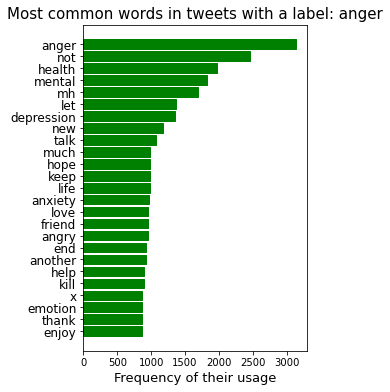

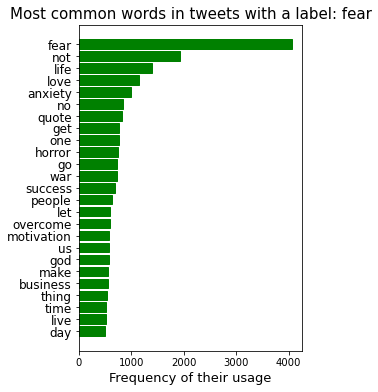

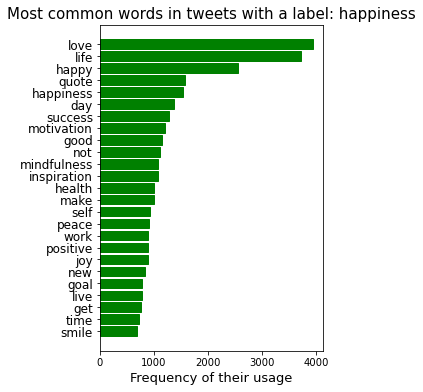

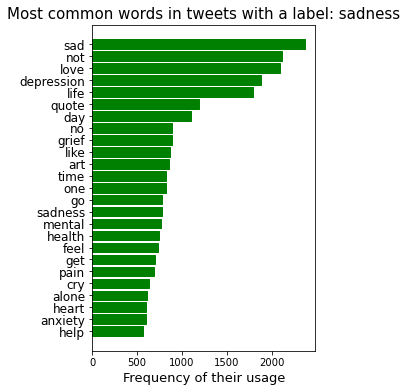

In [102]:
emotions = ['anger', 'fear', 'happiness', 'sadness']
create_bar_charts_for_all_labels(emotions, final_training_dataset)

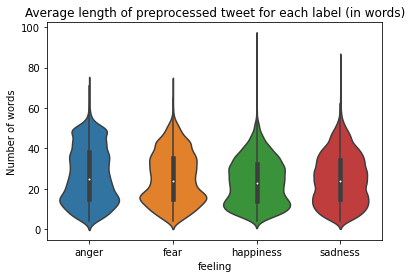

In [103]:
create_violin_plot_tweets_length(final_training_dataset)

# 7. COVID-19 dataset

# 7.1. Neutral tweets detection and removal

In [83]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

# analyses sentiment of one tweets
def sentiment_analyzer_scores(text):
    score = analyser.polarity_scores(text)
    lb = score['compound']
    if lb >= 0.05:
        return 1
    elif (lb > -0.05) and (lb < 0.05):
        return 0
    else:
        return -1

# adds sentiment labels to entire dataset
def add_sentiment_label(dataset):
    dataset['sentiment'] = dataset['text'].apply(lambda x: sentiment_analyzer_scores(x))
    return dataset

# removes neutral tweets out of the dataset
def take_neutral_tweets_out(dataset):
    neutral = dataset['sentiment'] == 0
    neutral_ds = dataset[neutral]
    dataset = dataset.drop(neutral_ds.index)
    dataset.reset_index(drop=True, inplace=True)
    display(neutral_ds.head())
    return dataset

def neutral_tweets_removal(dataset):
    return take_neutral_tweets_out(add_sentiment_label(dataset))

print("Examples of neutral tweets that were removed")
no_neutral_tweets_dataset = neutral_tweets_removal(all_months_dataset)

Examples of neutral tweets that were removed


,created_at,id,lang,hashtags,text,sentiment
6,2020-02-28 00:48:45+00:00,1233192279361323000,en,[],Obamacare architect Dr. Ezekiel Emanuel rushes in to try to score political points off of the coronavirus. https://t.co/HjZTkrAZ9j,0
10,2020-02-26 23:48:09+00:00,1232814641019048000,en,[],"Breaking: First U.S coronavirus case of unknown origin confirmed in Northern California, a sign the virus may be spreading in a local area https://t.co/vKUxAjdwP4",0
13,2020-02-27 22:00:31+00:00,1233149942040027100,en,[],First Coronavirus Case from Unknown Origin Reported https://t.co/YnhDo1kt81,0
14,2020-02-12 14:00:07+00:00,1227593227441602600,en,[],Investors charge back into stocks on signs coronavirus spread is slowing https://t.co/ewoUpf8e4j,0
17,2020-02-07 19:53:05+00:00,1225870115113230300,en,[],White House holds briefing on coronavirus https://t.co/rUrlL18X6B,0


In [84]:
print("before removing neutral tweets: ", len(all_months_dataset))
print("after removing neutral tweets: ", len(no_neutral_tweets_dataset))

before removing neutral tweets:  250321
after removing neutral tweets:  198106


# 7.2. Preprocessing pt. 2

In [69]:
# performs necessary cleaning and preprocessing actions
def clean_and_preprocess_month_datasets(months_dataset):
    dataset = months_dataset.copy()
    # fill all 'NaN' values with an empty string
    dataset = dataset.fillna('')
    # converts a string of hashtags into a list
    dataset['hashtags'] = dataset['hashtags'].apply(hashtags_to_list)
    # segments hashtags in text
    dataset_text_segmented_hashtags = first_cleaning(dataset)
    dataset['segmented_#_text'] = dataset_text_segmented_hashtags
    print("Hashtags segmented")
    # preprocesses the text with segmented hashtags
    dataset['pre_text'] = preprocess_data(dataset['segmented_#_text'])
    # count how many words there are after preprocessing, as some will have to be dropped later on
    dataset['pre_num_of_words'] = dataset['pre_text'].apply(len)
    print("Dataset preprocessed")
    dataset = dataset.drop(dataset[dataset.pre_num_of_words < 4].index)
    dataset.reset_index(drop=True, inplace=True)
    return dataset
 
preprocessed_covid_dataset = clean_and_preprocess_month_datasets(no_neutral_tweets_dataset)
preprocessed_covid_dataset.to_csv("preprocess_covid_dataset.csv", index = False, header = True)

Hashtags segmented
Replacing abbreviations...
Removing punctuation...
Tokenising...
Lemmatising ...
Removing tweet keywords...
Dataset preprocessed


In [5]:
# run below to read dataset into variable
preprocessed_covid_dataset = pd.read_csv('preprocess_covid_dataset.csv', sep=",")
preprocessed_covid_dataset['pre_text'] = preprocessed_covid_dataset['pre_text'].apply(ast.literal_eval)
preprocessed_covid_dataset.tail(5)

,created_at,id,lang,hashtags,text,sentiment,segmented_#_text,pre_text,pre_num_of_words
196104,2020-08-01 00:34:05+00:00,1289358708800028700,en,['[]'],"Ka-boom. Fauci drops some science truth bomb on @RepBlaine. Just cuz it’s peer reviewed and on internet doesn’t make it right. Study quality and design matters. If only there was a body of experts that reviews that... (checks notes)... oh, the FDA! Which blocked HCQ use. #COVID19 https://t.co/nw2JgME5Qt",-1,"Ka-boom. Fauci drops some science truth bomb on @RepBlaine. Just cuz it’s peer reviewed and on internet doesn’t make it right. Study quality and design matters. If only there was a body of experts that reviews that... (checks notes)... oh, the FDA! Which blocked HCQ use. #COVID19 https://t.co/nw2JgME5Qt","[ka, boom, fauci, drop, some, science, truth, bomb, on, just, cuz, it, be, peer, review, and, on, internet, do, not, make, it, right, study, quality, and, design, matter, if, only, there, be, a, body, of, expert, that, review, that, check, note, oh, the, fda, which, block, hcq, use, covid]",49
196105,2020-07-31 18:36:52+00:00,1289268812194254800,en,['[]'],Pastor tests positive for coronavirus one week after attending round table event with Trump – Raw Story https://t.co/NJB0VRzdti,1,Pastor tests positive for coronavirus one week after attending round table event with Trump – Raw Story https://t.co/NJB0VRzdti,"[pastor, test, positive, for, coronavirus, one, week, after, attend, round, table, event, with, trump, –, raw, story]",17
196106,2020-07-31 23:42:48+00:00,1289345799759921200,en,['[]'],Volusia Sheriff Mike Chitwood tests positive for coronavirus\nhttps://t.co/Ikj6CZrqsf,1,Volusia Sheriff Mike Chitwood tests positive for coronavirus\nhttps://t.co/Ikj6CZrqsf,"[volusia, sheriff, mike, chitwood, test, positive, for, coronavirus]",8
196107,2020-07-31 14:38:37+00:00,1289208851850391600,en,['[]'],"Asked why the US coronavirus outbreak is so much worse than it has been in Europe, Dr. Fauci explains that state shutdown orders didn't go far enough and were rescinded too soon https://t.co/RUD5KyPNGh",-1,"Asked why the US coronavirus outbreak is so much worse than it has been in Europe, Dr. Fauci explains that state shutdown orders didn't go far enough and were rescinded too soon https://t.co/RUD5KyPNGh","[ask, why, the, us, coronavirus, outbreak, be, so, much, bad, than, it, have, be, in, europe, dr, fauci, explain, that, state, shutdown, order, do, not, go, far, enough, and, be, rescind, too, soon]",33
196108,2020-07-31 16:09:41+00:00,1289231769066143700,en,['[]'],BREAKING: Florida breaks COVID-19 death record for 4th day in a row with 257 new deaths which is one death every 5-6 minutes.,-1,BREAKING: Florida breaks COVID-19 death record for 4th day in a row with 257 new deaths which is one death every 5-6 minutes.,"[break, florida, break, covid, death, record, for, th, day, in, a, row, with, new, death, which, be, one, death, every, minute]",21


# 8. Emotion detection from COVID-19 dataset

# 8.1. For the chosen time period from February to August (not including)

In [14]:
# predicts emotion of each tweet in the dataset and assigns predicted label to it
def predict_emotions_in_covid_datasets(clf, tfidf, df):
    dataset = df.copy()
    tokens_only = dataset['pre_text']
    features_tweets = tfidf.transform(tokens_only)
    predictions = clf.predict(features_tweets)
    dataset["feeling"] = lb.inverse_transform(predictions)
    return dataset

labelled_all_months = predict_emotions_in_covid_datasets(final_classifier, final_tfidf, preprocessed_covid_dataset)
labelled_all_months.to_csv("labelled_all_months.csv", index = False, header = True)

In [8]:
# run below to read dataset into variable
labelled_all_months = pd.read_csv('labelled_all_months.csv', sep=",")
labelled_all_months['pre_text'] = labelled_all_months['pre_text'].apply(ast.literal_eval)
labelled_all_months.head(50)

,created_at,id,lang,hashtags,text,sentiment,segmented_#_text,pre_text,pre_num_of_words,feeling
0,2020-02-28 08:19:59+00:00,1233305835968876500,en,['[]'],Live updates: Coronavirus pummels Asian financial markets as deadly outbreak rages https://t.co/ENiHptBctb,-1,Live updates: Coronavirus pummels Asian financial markets as deadly outbreak rages https://t.co/ENiHptBctb,"[live, update, coronavirus, pummels, asian, financial, market, as, deadly, outbreak, rage]",11,anger
1,2020-02-26 16:35:39+00:00,1232705798821863400,en,['[]'],*coronavirus spreads*\n\nnormal countries: oh no! let's hope to find a cure soom\nitaly: WHY ARE OUR PASTA SHELVES EMPTY OH MY GOD ALL WE HAVE LEFT ARE THE PENNE LISCE,1,*coronavirus spreads*\n\nnormal countries: oh no! let's hope to find a cure soom\nitaly: WHY ARE OUR PASTA SHELVES EMPTY OH MY GOD ALL WE HAVE LEFT ARE THE PENNE LISCE,"[coronavirus, spread, normal, country, oh, no, let, us, hope, to, find, a, cure, soom, italy, why, be, our, pasta, shelf, empty, oh, my, god, all, we, have, leave, be, the, penne, lisce]",32,sadness
2,2020-02-02 17:14:32+00:00,1224018275371225000,en,['[]'],"yixing donated 100,000 rmb through his studio to the wuhan red cross society to help combat coronavirus @layzhang ♥️ https://t.co/kkAVAnIOf5",1,"yixing donated 100,000 rmb through his studio to the wuhan red cross society to help combat coronavirus @layzhang ♥️ https://t.co/kkAVAnIOf5","[yixing, donate, rmb, through, his, studio, to, the, wuhan, red, cross, society, to, help, combat, coronavirus, ♥, ️]",18,anger
3,2020-02-28 16:40:05+00:00,1233431690225184800,en,['[]'],"Mick Mulvaney at CPAC: Coronavirus is the Dem’s new favorite hoax. They want to bring down the President. \n\n- audience cheers\n\nAlso Mick Mulvaney at CPAC: you’ll probably see some schools close.\n\n- audience cheers\n\nNot a fucking cult, though.",1,"Mick Mulvaney at CPAC: Coronavirus is the Dem’s new favorite hoax. They want to bring down the President. \n\n- audience cheers\n\nAlso Mick Mulvaney at CPAC: you’ll probably see some schools close.\n\n- audience cheers\n\nNot a fucking cult, though.","[mick, mulvaney, at, cpac, coronavirus, be, the, dem, s, new, favorite, hoax, they, want, to, bring, down, the, president, audience, cheer, also, mick, mulvaney, at, cpac, you, will, probably, see, some, school, close, audience, cheer, not, a, fucking, cult, though]",40,sadness
4,2020-02-24 18:54:21+00:00,1232015928075968500,en,['[]'],"The coronavirus story will also become a health-insurance story in America. This guy went to China, caught the flu, came back, did the responsible thing and reported himself for possible coronavirus — but tested negative and now might have to pay $1,400+. https://t.co/GdDqyODPVw",-1,"The coronavirus story will also become a health-insurance story in America. This guy went to China, caught the flu, came back, did the responsible thing and reported himself for possible coronavirus — but tested negative and now might have to pay $1,400+. https://t.co/GdDqyODPVw","[the, coronavirus, story, will, also, become, a, health, insurance, story, in, america, this, guy, go, to, china, caught, the, flu, come, back, do, the, responsible, thing, and, report, himself, for, possible, coronavirus, —, but, test, negative, and, now, might, have, to, pay]",42,fear
5,2020-02-25 14:20:21+00:00,1232309361596346400,en,['[]'],"While the world fights the Coronavirus, \nIndians, lucky to avoid it so far, are busy fighting amongst each other.",-1,"While the world fights the Coronavirus, \nIndians, lucky to avoid it so far, are busy fighting amongst each other.","[while, the, world, fight, the, coronavirus, indians, lucky, to, avoid, it, so, far, be, busy, fight, amongst, each, other]",19,anger
6,2020-02-02 01:23:37+00:00,1223778969348182000,en,"[""['2019nCoV']""]",1/THREAD\n\nPREDICTION: #2019nCoV infection rate will fall off prior exponential trajectory being tracked by @chrismartenson and @biancoresearch creating a sense of relief that the crisis probabl

# 8.2. Emotion patterns and analysis

# 8.2.1. Functions

In [15]:
# changes date format from string to datetime type in the dataset
def change_date_format(old_dataset):
    dataset = old_dataset.copy()
    dataset["created_at"] = pd.to_datetime(dataset["created_at"], format='%Y-%m-%d %H:%M:%S%z')
    dataset["created_at"] = dataset["created_at"].apply(lambda x: x.date())
    dataset = dataset.sort_values('created_at', ascending=True)
    return dataset

# calculates the percentage of tweet for each emotion for each day
def calculate_feelings_each_day(dataset):
    days = dataset['created_at'].unique()
    anger_by_day = []
    fear_by_day = []
    happiness_by_day = []
    sadness_by_day = []
    
    for day in days:
        anger_count = dataset[(dataset.created_at == day) & (dataset.feeling == 'anger')].count()["created_at"]
        fear_count = dataset[(dataset.created_at == day) & (dataset.feeling == 'fear')].count()["created_at"]
        happiness_count = dataset[(dataset.created_at == day) & (dataset.feeling == 'happiness')].count()["created_at"]
        sadness_count = dataset[(dataset.created_at == day) & (dataset.feeling == 'sadness')].count()["created_at"]
        total_count = anger_count + fear_count + happiness_count + sadness_count

        anger_by_day.append(anger_count/total_count*100)
        fear_by_day.append(fear_count/total_count*100)
        happiness_by_day.append(happiness_count/total_count*100)
        sadness_by_day.append(sadness_count/total_count*100)
    
    return pd.DataFrame({'date':days, 'anger':anger_by_day, 'fear':fear_by_day, 'happiness':happiness_by_day, 'sadness':sadness_by_day})

# shows plots of emotion patterns
def plot_emotion_patterns(feelings_count_per_day, title, interval, width, height):
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot('date', 'anger', data=feelings_count_per_day, markersize=6, color='#66c2a5', linewidth=2)
    ax.plot('date', 'fear', data=feelings_count_per_day, markersize=6, color='#8da0cb', linewidth=2)
    ax.plot('date', 'happiness', data=feelings_count_per_day, markersize=6, color='#e78ac3', linewidth=2)
    ax.plot('date', 'sadness', data=feelings_count_per_day, markersize=6, color='#ffd92f', linewidth=2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fmt_day = mdates.DayLocator(interval=interval)
    ax.xaxis.set_major_locator(fmt_day)
    fig.autofmt_xdate()
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Percentage of tweets of given emotion in a day")
    plt.show()
    
# performs analysis of one month that includes label distribution in a month and emotion patterns plot
def perform_one_month_analysis(all_months_dataset, start_date, end_date, month):
    labelled = all_months_dataset[(all_months_dataset['created_at'] >= start_date) & (all_months_dataset['created_at'] <= end_date)]

    print(labelled.groupby(['feeling'])['text'].count())
    title1 = "Emotion labels distribution - " + month
    plt.title(title1)
    sns.countplot(x=(labelled['feeling']), order=['anger','fear','happiness','sadness'])

    feelings_count_per_day_feb = calculate_feelings_each_day(labelled)
    title2 = "Emotion patterns in " + month
    plot_emotion_patterns(feelings_count_per_day_feb, title2, 2, 7, 4)

# 8.2.2. 1st of Feb to 31st of July

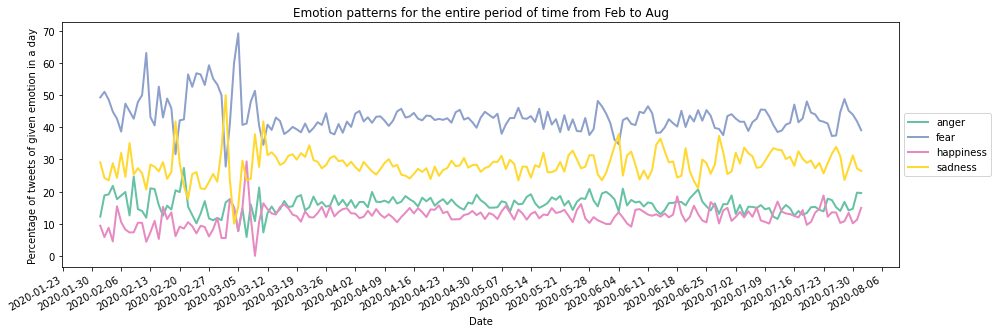

feeling
anger        31645
fear         83035
happiness    25128
sadness      56301
Name: text, dtype: int64


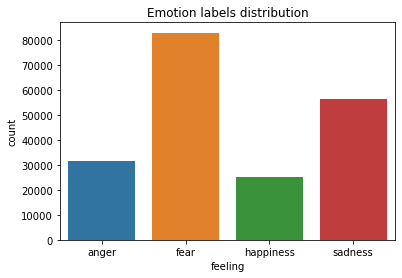

In [16]:
# emotion patterns
final_labelled_all_months = change_date_format(labelled_all_months)
feelings_count_per_day_all_months = calculate_feelings_each_day(final_labelled_all_months)
plot_emotion_patterns(feelings_count_per_day_all_months, "Emotion patterns for the entire period of time from Feb to Aug", 7, 15, 5)

# emotion label distribution
print(final_labelled_all_months.groupby(['feeling'])['text'].count())
plt.title("Emotion labels distribution")
sns.countplot(x=(final_labelled_all_months['feeling']), order=['anger','fear','happiness','sadness'])

In [20]:
final_labelled_all_months.reset_index(drop=True, inplace=True)
final_labelled_all_months.head(50)

,created_at,id,lang,hashtags,text,sentiment,segmented_#_text,pre_text,pre_num_of_words,feeling
0,2020-02-01,1223722270734069800,en,['[]'],"BREAKING: Two patients in England, who are members of the same family, have tested positive for coronavirus.\n\nRead more here: https://t.co/ENM2x650O7 https://t.co/dh5dOdnKdG",1,"BREAKING: Two patients in England, who are members of the same family, have tested positive for coronavirus.\n\nRead more here: https://t.co/ENM2x650O7 https://t.co/dh5dOdnKdG","[break, two, patient, in, england, who, be, member, of, the, same, family, have, test, positive, for, coronavirus, read, more, here]",20,happiness
1,2020-02-01,1223681250428248000,en,['[]'],India has evacuated and Pakistan abandoned its students in Coronavirus hit Wuhan. Still likes of @ArvindKejriwal call Modi a fascist like Pakistani PM. https://t.co/j9f3j2Idqz,-1,India has evacuated and Pakistan abandoned its students in Coronavirus hit Wuhan. Still likes of @ArvindKejriwal call Modi a fascist like Pakistani PM. https://t.co/j9f3j2Idqz,"[india, have, evacuate, and, pakistan, abandon, its, student, in, coronavirus, hit, wuhan, still, like, of, call, modi, a, fascist, like, pakistani, pm]",22,sadness
2,2020-02-01,1223725370337157000,en,['[]'],"Corona virus is not a joke;\n\nLord, please protect my family, friends, and also humanities.",1,"Corona virus is not a joke;\n\nLord, please protect my family, friends, and also humanities.","[corona, virus, be, not, a, joke, lord, please, protect, my, family, friend, and, also, humanity]",15,sadness
3,2020-02-01,1223418947070054400,en,['[]'],"Your racist jokes about dying of coronavirus are all so tired. The flu killed 80,000 ppl in the US in 2018 alone, but I guess you’re not worried about that since it’s not racialized as carried by dirty orientals the way coronavirus is",-1,"Your racist jokes about dying of coronavirus are all so tired. The flu killed 80,000 ppl in the US in 2018 alone, but I guess you’re not worried about that since it’s not racialized as carried by dirty orientals the way coronavirus is","[your, racist, joke, about, die, of, coronavirus, be, all, so, tire, the, flu, kill, ppl, in, the, us, in, alone, but, i, guess, you, be, not, worry, about, that, since, it, be, not, racialized, as, carry, by, dirty, oriental, the, way, coronavirus, be]",43,fear
4,2020-02-01,1223613684406259700,en,['[]'],"He is Dr. Liang Wudong,\nWho Died treating Corona virus in China. He was Treating Patients Despite knowing he may not survive this Man Deserves our endless respect For his bravery.\n#coronavirus https://t.co/Xp2Jtxzc7Y",1,"He is Dr. Liang Wudong,\nWho Died treating Corona virus in China. He was Treating Patients Despite knowing he may not survive this Man Deserves our endless respect For his bravery.\n#coronavirus https://t.co/Xp2Jtxzc7Y","[he, be, dr, liang, wudong, who, die, treat, corona, virus, in, china, he, be, treat, patient, despite, know, he, may, not, survive, this, man, deserve, our, endless, respect, for, his, bravery, coronavirus]",32,fear
5,2020-02-01,1223716969146351600,en,"[""['coronavirus']""]","This seems to be an acknowledgement of a backlog of testing on the #coronavirus in China. That said, the WHO does think we can still stop the spread of the virus. Good article: https://t.co/zCjhBHUcsP https://t.co/72034F8bcq",1,"This seems to be an acknowledgement of a backlog of testing on the #coronavirus in China. That said, the WHO does think we can still stop the spread of the virus. Good article: https://t.co/zCjhBHUcsP https://t.co/72034F8bcq","[this, seem, to, be, an, acknowledgement, of, a, backlog, of, test, on, the, coronavirus, in, china, that, say, the, who, do, think, we, can, still, stop, the, spread, of, the, virus, good, article]",33,fear
6,2020-02-01,1223590712190455800,en,['[]'],"Tangina lawyer ka, nag rt ka na dapat mag declare ng martial law?????? to stop????? the spread of the????? corona virus??????? \n\nCONSTITUTION WHOMSTVED\nINVASION OR REBELLION OF THE nCOV

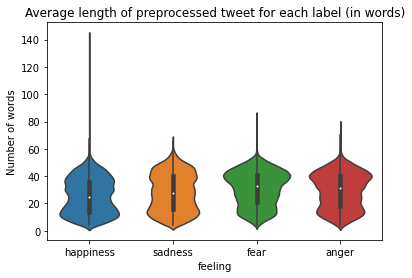

In [22]:
# average tweet length for each emotion
create_violin_plot_tweets_length(final_labelled_all_months)

Pt 1 took 344.63063526153564 to run
Pt 2 took 1.009868860244751 to run
Pt 3 took 0.03126263618469238 to run


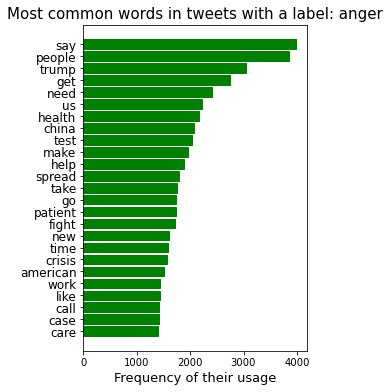

Pt 1 took 2475.78262925148 to run
Pt 2 took 3.535003423690796 to run
Pt 3 took 0.12999987602233887 to run


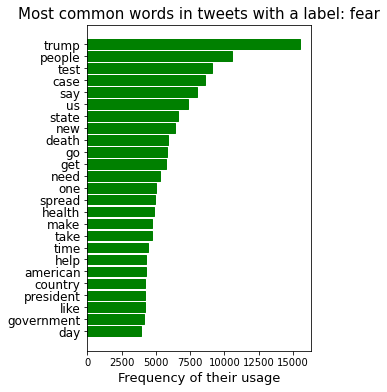

Pt 1 took 241.7317042350769 to run
Pt 2 took 0.6970024108886719 to run
Pt 3 took 0.03203606605529785 to run


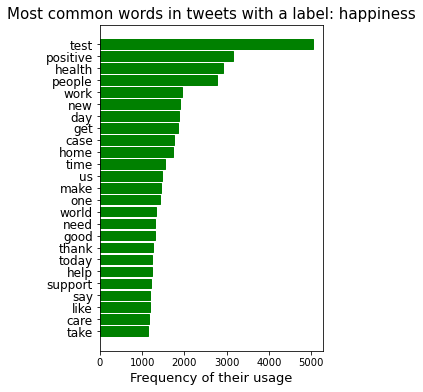

Pt 1 took 1289.9944400787354 to run
Pt 2 took 1.6760175228118896 to run
Pt 3 took 0.05994677543640137 to run


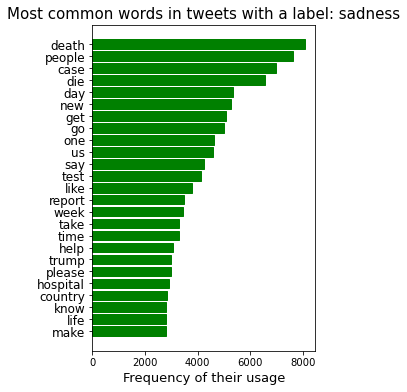

In [24]:
# most common words for each emotion
emotions = ['anger', 'fear', 'happiness', 'sadness']
create_bar_charts_for_all_labels(emotions, final_labelled_all_months)

# 8.2.3. February

feeling
anger        1096
fear         3927
happiness     669
sadness      1882
Name: text, dtype: int64


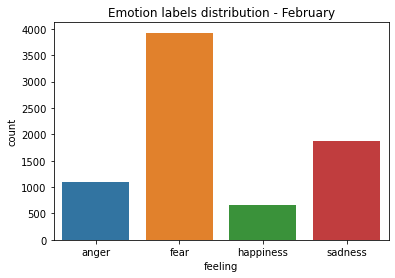

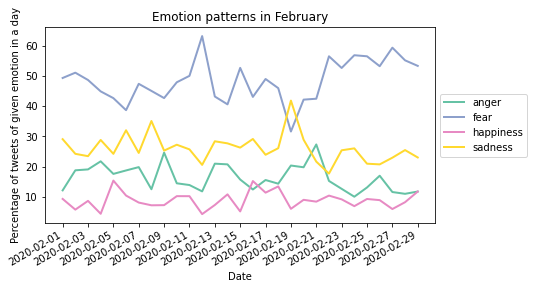

In [18]:
perform_one_month_analysis(final_labelled_all_months, date(2020, 2, 1), date(2020, 2, 29), "February")

# 8.2.4. March

feeling
anger         6123
fear         15378
happiness     5167
sadness      11624
Name: text, dtype: int64


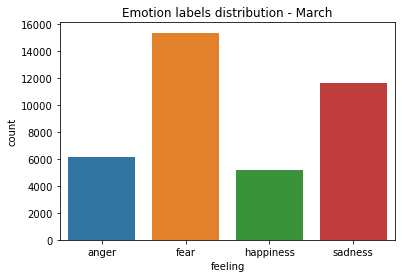

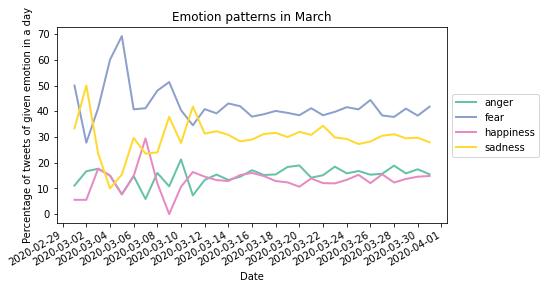

In [19]:
perform_one_month_analysis(final_labelled_all_months, date(2020, 3, 1), date(2020, 3, 31), "March")

# 8.2.5. April

feeling
anger         6577
fear         16842
happiness     5105
sadness      10669
Name: text, dtype: int64


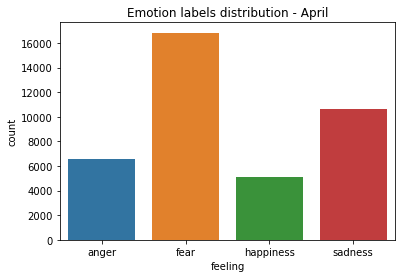

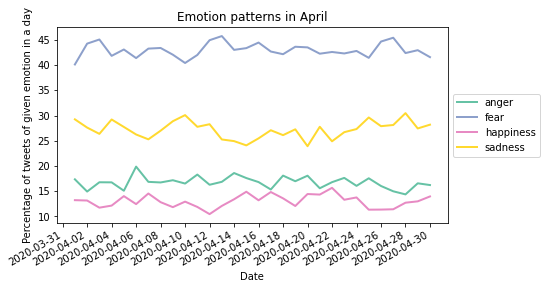

In [20]:
perform_one_month_analysis(final_labelled_all_months, date(2020, 4, 1), date(2020, 4, 30), "April")

# 8.2.6. May

feeling
anger         6583
fear         16502
happiness     5036
sadness      11018
Name: text, dtype: int64


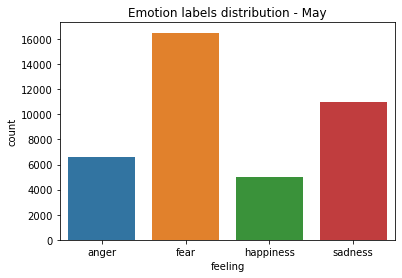

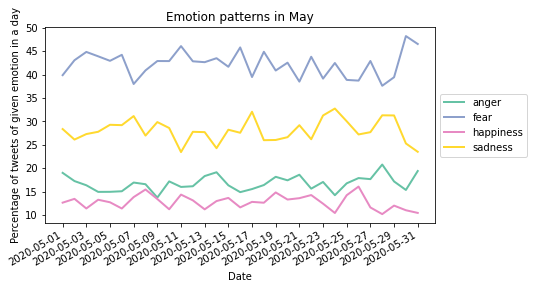

In [21]:
perform_one_month_analysis(final_labelled_all_months, date(2020, 5, 1), date(2020, 5, 31), "May")

# 8.2.7. June

feeling
anger         5648
fear         14270
happiness     4382
sadness       9862
Name: text, dtype: int64


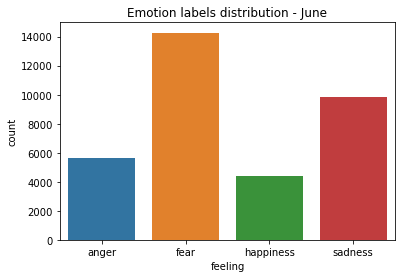

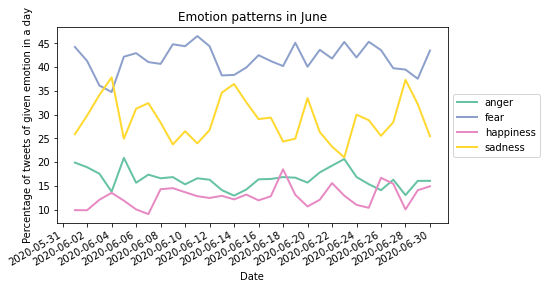

In [22]:
perform_one_month_analysis(final_labelled_all_months, date(2020, 6, 1), date(2020, 6, 30), "June")

# 8.2.8. July

feeling
anger         5584
fear         16048
happiness     4743
sadness      11200
Name: text, dtype: int64


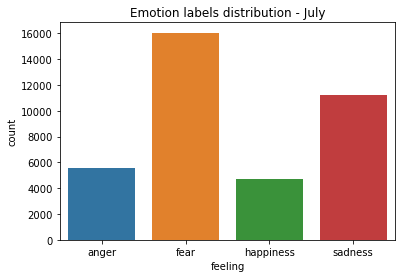

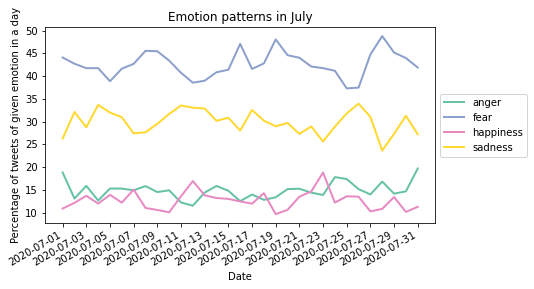

In [23]:
perform_one_month_analysis(final_labelled_all_months, date(2020, 7, 1), date(2020, 7, 31), "July")

In [124]:
# fin